## Jaccard and Adamic-Adar on Connected vs. Disconnected Pairs

We will focus on the following similarity scores for a subgraph of Facebook:

1. **Jaccard similarity**
   - Measures similarity based on the overlap of neighborhoods.

2. **Adamic---Adar similarity**
   - Also uses common neighbors, but assigns more weight to
     *rare* neighbors (low-degree common neighbors).

### Experiment design

We construct two datasets of node pairs:
- **Connected pairs:** sampled from existing edges in the network.
- **Disconnected pairs:** sampled from pairs of nodes that are not connected.

For each pair, we compute:
- the Jaccard similarity score, and
- the Adamic-Adar similarity score,

and then compare their empirical distributions.

This provides a simple empirical diagnostic:
**Do similarity scores tend to be larger for connected nodes than for disconnected ones?**

## Loading the Facebook Network

We begin by loading a small Facebook friendship network into our Python
environment.

The dataset is stored as an **edge list**, where each line contains two
integers representing a friendship between two users.
The file is hosted in a public GitHub repository, so this notebook can be
run anywhere without requiring external storage services.

We will download the file if it is not already present locally, and then
use NetworkX to construct an undirected graph.

In [2]:
import networkx as nx
import urllib.request
from pathlib import Path

# -----------------------------
# Dataset location (GitHub)
# -----------------------------
DATA_URL = "https://raw.githubusercontent.com/vmpreciado/DS4CN/main/FacebookSmall.txt"
LOCAL_FILE = Path("FacebookSmall.txt")


# -----------------------------
# Download the dataset if needed
# -----------------------------
def looks_like_html(path: Path, nbytes: int = 200) -> bool:
    """Check whether a file accidentally contains HTML instead of data."""
    try:
        head = path.read_text(encoding="utf-8", errors="ignore")[:nbytes].lower()
    except Exception:
        return False
    return "<!doctype" in head or "<html" in head


need_download = (not LOCAL_FILE.exists()) or looks_like_html(LOCAL_FILE)

if need_download:
    if LOCAL_FILE.exists():
        print("Local file exists but appears invalid. Re-downloading...")
    else:
        print("Downloading Facebook edge list from GitHub...")
    urllib.request.urlretrieve(DATA_URL, LOCAL_FILE)
    print(f"Download completed: {LOCAL_FILE.resolve()}")
else:
    print(f"Using local file: {LOCAL_FILE.resolve()}")

# -----------------------------
# Load the graph
# -----------------------------
FB = nx.read_edgelist(
    LOCAL_FILE,
    create_using=nx.Graph(),  # undirected friendship network
    nodetype=int
)

# -----------------------------
# Sanity checks
# -----------------------------
print("Facebook graph loaded successfully.")
print(f"  nodes: {FB.number_of_nodes():,}")
print(f"  edges: {FB.number_of_edges():,}")
print(f"  directed?: {FB.is_directed()}")

Using local file: /Users/victormpreciado/Library/Application Support/JetBrains/DataSpell2025.1/projects/workspace/FacebookSmall.txt
Facebook graph loaded successfully.
  nodes: 4,039
  edges: 88,234
  directed?: False


## Sampling Node Pairs and Computing Similarity Scores

We now generate a dataset of **node pairs** and compute their similarity scores
using the **Jaccard** and **Adamic–Adar** indices.

### Sampling strategy
We repeatedly sample pairs of distinct nodes $(i,j)$ uniformly at random and
separate them into two groups:
- **Connected pairs:** node pairs that are directly linked by an edge.
- **Disconnected pairs:** node pairs that are not linked by an edge.

We continue sampling until we collect:
- 10,000 connected pairs, and
- 10,000 disconnected pairs.

This balanced setup makes it easier to compare similarity scores for existing
edges versus non-edges.

### Similarity computation
For each sampled pair $(i,j)$, we compute:
- the **Jaccard similarity**, based on the overlap between their neighborhoods,
- the **Adamic–Adar similarity**, which gives more weight to rare (low-degree)
  common neighbors.

The resulting scores are stored separately for connected and disconnected pairs.
These collections will later be used to compare distributions and assess how
well each similarity measure distinguishes edges from non-edges.

In [4]:
import random
import numpy as np

# ------------------------------------------------------------
# Reproducibility
# ------------------------------------------------------------
# Fixing the random seed ensures that every run of the notebook
# produces the same random samples and the same plots.
SEED = 7
random.seed(SEED)
np.random.seed(SEED)

# ------------------------------------------------------------
# Parameters controlling the experiment
# ------------------------------------------------------------
# Number of connected (positive) and disconnected (negative) pairs
N_POS = 10_000
N_NEG = 10_000

# Safety cap to avoid an infinite loop in dense graphs
MAX_TRIES = 2_000_000

# ------------------------------------------------------------
# Basic graph data
# ------------------------------------------------------------
# Degree of each node (needed for Adamic-Adar)
degrees = dict(FB.degree())

# List of nodes (used for random sampling)
nodes = list(FB.nodes())

# Precompute neighbor sets for efficiency:
# this avoids calling FB.neighbors(i) repeatedly inside the loop
neighbors = {u: set(FB.neighbors(u)) for u in nodes}

# ------------------------------------------------------------
# Containers for similarity scores
# ------------------------------------------------------------
# Scores for connected node pairs
connected_jaccard = []
connected_adamic_adar = []

# Scores for disconnected node pairs
disconnected_jaccard = []
disconnected_adamic_adar = []

# ------------------------------------------------------------
# Random sampling loop
# ------------------------------------------------------------
tries = 0

# Continue sampling until we collect enough connected AND disconnected pairs
while (len(connected_jaccard) < N_POS or len(disconnected_jaccard) < N_NEG) and tries < MAX_TRIES:
    tries += 1

    # Sample two distinct nodes uniformly at random
    i, j = random.sample(nodes, 2)

    # --------------------------------------------------------
    # Compute neighborhood-based quantities
    # --------------------------------------------------------
    neighbors_i = neighbors[i]
    neighbors_j = neighbors[j]

    # Common neighbors (intersection)
    common_neighbors = neighbors_i & neighbors_j

    # Union of neighborhoods (needed for Jaccard)
    all_neighbors = neighbors_i | neighbors_j

    # --------------------------------------------------------
    # Jaccard similarity
    # --------------------------------------------------------
    # Defined as |N(i) ∩ N(j)| / |N(i) ∪ N(j)|
    # If both neighborhoods are empty, define similarity as 0
    if all_neighbors:
        jaccard_index = len(common_neighbors) / len(all_neighbors)
    else:
        jaccard_index = 0.0

    # --------------------------------------------------------
    # Adamic-Adar similarity
    # --------------------------------------------------------
    # Sum over common neighbors, weighted by 1 / log(degree)
    # We skip neighbors with degree <= 1 to avoid log(1)=0
    adamic_adar_index = 0.0
    for k in common_neighbors:
        dk = degrees[k]
        if dk > 1:
            adamic_adar_index += 1.0 / np.log(dk)

    # --------------------------------------------------------
    # Separate connected vs disconnected pairs
    # --------------------------------------------------------
    if FB.has_edge(i, j):
        # Store scores for connected pairs (up to N_POS)
        if len(connected_jaccard) < N_POS:
            connected_jaccard.append(jaccard_index)
            connected_adamic_adar.append(adamic_adar_index)
    else:
        # Store scores for disconnected pairs (up to N_NEG)
        if len(disconnected_jaccard) < N_NEG:
            disconnected_jaccard.append(jaccard_index)
            disconnected_adamic_adar.append(adamic_adar_index)

# ------------------------------------------------------------
# Final sanity check
# ------------------------------------------------------------
if len(connected_jaccard) < N_POS or len(disconnected_jaccard) < N_NEG:
    raise RuntimeError(
        f"Stopped after {tries:,} attempts. Collected "
        f"{len(connected_jaccard):,}/{N_POS:,} connected and "
        f"{len(disconnected_jaccard):,}/{N_NEG:,} disconnected pairs. "
        "Try reducing N_POS/N_NEG or increasing MAX_TRIES."
    )

print("Sampling complete:")
print(f"  connected pairs:    {len(connected_jaccard):,}")
print(f"  disconnected pairs: {len(disconnected_jaccard):,}")
print(f"  attempts:           {tries:,}")

Sampling complete:
  connected pairs:    10,000
  disconnected pairs: 10,000
  attempts:           911,410


## Comparing Similarity Distributions for Connected and Disconnected Pairs

The next code cell visualizes how **similarity scores are distributed** for
different types of node pairs in the network.

Specifically, we plot **histograms** of:
- the **Jaccard similarity**, and
- the **Adamic---Adar similarity**

for two classes of node pairs:
- **Connected pairs** (blue): pairs of nodes that are linked by an edge.
- **Disconnected pairs** (red): pairs of nodes that are not linked by an edge.

### Why histograms?
Histograms allow us to compare the *entire distribution* of similarity scores,
not just their average values. This is important because:
- link prediction depends on how well scores separate connected from disconnected pairs,
- significant overlap between the two distributions makes prediction harder.

### How to read the plots
- If the **blue histogram** (connected pairs) is shifted to the right relative
  to the **red histogram** (disconnected pairs), then the similarity score
  tends to assign larger values to true edges.
- If the two histograms overlap heavily, the similarity measure has limited
  discriminative power.
- A long right tail in the connected distribution often indicates the presence
  of strongly predictive node pairs.

These plots provide a first, intuitive assessment of whether a similarity
measure is useful for **link prediction** in this network.

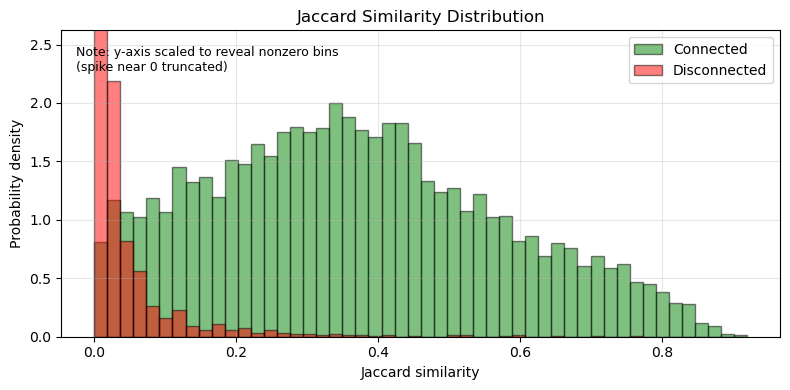

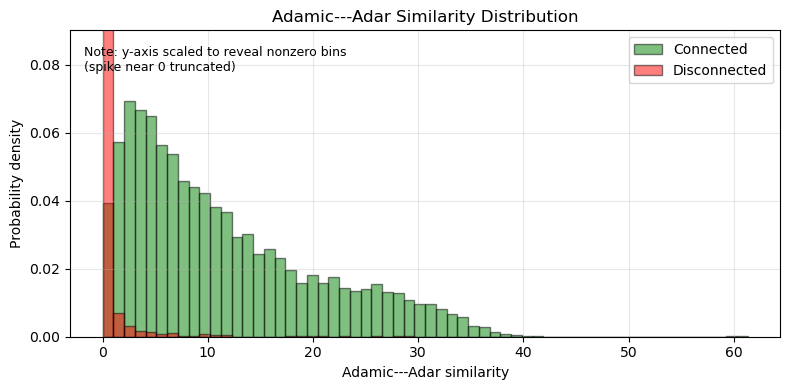

In [20]:
import numpy as np
import matplotlib.pyplot as plt


def plot_histogram_truncate_zero_bin(
        pos_scores,
        neg_scores,
        title,
        xlabel,
        bins=50,
        headroom=1.10,
        spike_ratio=5.0
):
    """
    Plot a single histogram (linear y-axis) for connected vs disconnected pairs.
    If the bin containing zero dominates the distribution, truncate ONLY that bin
    so that the remaining bins are clearly visible.
    """
    pos_scores = np.asarray(pos_scores)
    neg_scores = np.asarray(neg_scores)

    # Common x-range
    lo = min(pos_scores.min(), neg_scores.min())
    hi = max(pos_scores.max(), neg_scores.max())
    if lo == hi:
        hi = lo + 1e-9

    # Compute histograms (density) to decide y-axis scaling
    hist_pos, bin_edges = np.histogram(
        pos_scores, bins=bins, range=(lo, hi), density=True
    )
    hist_neg, _ = np.histogram(
        neg_scores, bins=bins, range=(lo, hi), density=True
    )

    # Combine bin heights
    hist_all = np.maximum(hist_pos, hist_neg)

    # Identify bin containing zero
    zero_bin = np.searchsorted(bin_edges, 0.0, side="right") - 1
    zero_bin = int(np.clip(zero_bin, 0, len(hist_all) - 1))

    # Max height excluding the zero bin
    other_bins = np.delete(hist_all, zero_bin)
    max_other = other_bins.max() if len(other_bins) > 0 else hist_all.max()

    zero_height = hist_all[zero_bin]

    # Decide whether truncation is needed
    truncate = (max_other > 0) and (zero_height / max_other >= spike_ratio)

    if truncate:
        ymax = max_other * headroom
    else:
        ymax = hist_all.max() * headroom if hist_all.max() > 0 else 1.0

    # -------------------------
    # Plot
    # -------------------------
    plt.figure(figsize=(8, 4))

    plt.hist(
        pos_scores,
        bins=bins,
        range=(lo, hi),
        density=True,
        alpha=0.5,
        color="green",
        label="Connected",
        edgecolor="black",
    )
    plt.hist(
        neg_scores,
        bins=bins,
        range=(lo, hi),
        density=True,
        alpha=0.5,
        color="red",
        label="Disconnected",
        edgecolor="black",
    )

    plt.ylim(0, ymax)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel("Probability density")
    plt.grid(True, alpha=0.3)
    plt.legend(loc="upper right")

    if truncate:
        plt.text(
            0.02, 0.95,
            "Note: y-axis scaled to reveal nonzero bins\n(spike near 0 truncated)",
            transform=plt.gca().transAxes,
            fontsize=9,
            va="top"
        )

    plt.tight_layout()
    plt.show()


# ------------------------------------------------------------
# Jaccard similarity
# ------------------------------------------------------------
plot_histogram_truncate_zero_bin(
    connected_jaccard,
    disconnected_jaccard,
    title="Jaccard Similarity Distribution",
    xlabel="Jaccard similarity",
    bins=50,
    headroom=1.20,
    spike_ratio=5.0,
)

# ------------------------------------------------------------
# Adamic---Adar similarity
# ------------------------------------------------------------
plot_histogram_truncate_zero_bin(
    connected_adamic_adar,
    disconnected_adamic_adar,
    title="Adamic---Adar Similarity Distribution",
    xlabel="Adamic---Adar similarity",
    bins=60,
    headroom=1.30,
    spike_ratio=5.0,
)

## Conclusions From the Similarity Distributions

We now summarize the main observations from the histogram plots of the
Jaccard and Adamic-Adar similarity scores.

### Jaccard similarity
- For **connected pairs** (blue), the Jaccard index spans a broad range,
  roughly from 0 up to about 0.9, with many values concentrated in the
  mid-range (approximately 0.2 to 0.6).
- For **disconnected pairs** (red), the Jaccard index is heavily concentrated
  near zero. This indicates that most disconnected node pairs share
  few or no common neighbors.
- Overall, the Jaccard index does provide some separation between
  connected and disconnected pairs.

### Adamic---Adar similarity
- For **connected pairs** (blue), the Adamic-Adar index is broadly distributed
  and can take much larger values (often extending well beyond 10).
- For **disconnected pairs** (red), the Adamic-Adar scores are again mostly
  concentrated near zero, similar to what we observed for Jaccard.
- The key difference is that connected pairs tend to have
  **substantially larger Adamic-Adar scores**, leading to a clearer
  separation between connected and disconnected pairs.

### Key takeaway
Both similarity measures contain useful information for link prediction. In the next slide set we analyze the discriminative power of these indexes to predict links in the graph.

GO BACK TO SLIDES TO SEE HOW TO USE THESE HISTOGRAMS IN A CLASSIFICATION SETTING...

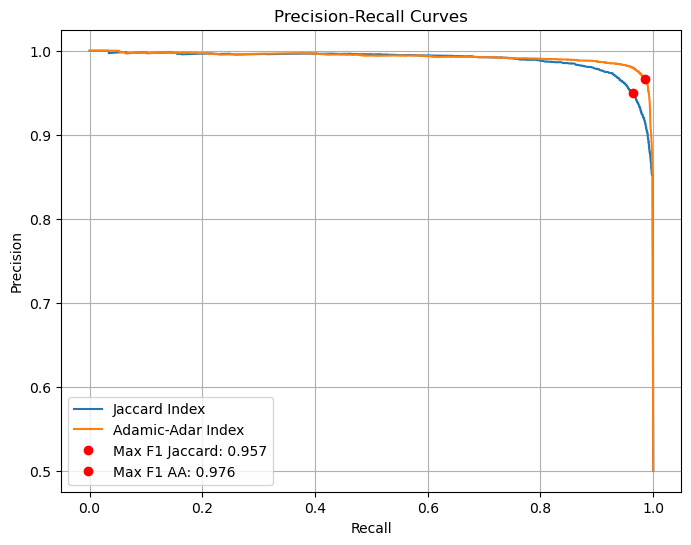

Optimal thresholds:
Jaccard: 0.0360
Adamic-Adar: 0.4499

Performance at optimal thresholds:
Jaccard:
Precision: 0.9499
Recall: 0.9645
F1: 0.9571

Adamic-Adar:
Precision: 0.9667
Recall: 0.9851
F1: 0.9758


In [13]:
import numpy as np
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

# Calculate priors based on network density
n_nodes = FB.number_of_nodes()
total_possible_pairs = n_nodes * (n_nodes-1) / 2
prior_connected = FB.number_of_edges() / total_possible_pairs
prior_disconnected = 1 - prior_connected

# Fit distributions to likelihood ratios
def fit_likelihood_ratio(connected_vals, disconnected_vals, bins=50):
   hist_conn, bins = np.histogram(connected_vals, bins=bins, density=True)
   hist_disconn, _ = np.histogram(disconnected_vals, bins=bins, density=True)
   # Add small constant to avoid division by zero
   likelihood_ratio = (hist_conn + 1e-10) / (hist_disconn + 1e-10)
   bin_centers = (bins[:-1] + bins[1:]) / 2
   return bin_centers, likelihood_ratio

# Calculate likelihood ratios for both metrics
jaccard_bins, jaccard_lr = fit_likelihood_ratio(connected_jaccard, disconnected_jaccard)
aa_bins, aa_lr = fit_likelihood_ratio(connected_adamic_adar, disconnected_adamic_adar)

# Make predictions and calculate metrics
def evaluate_predictions(values, threshold, true_connected):
   predictions = values >= threshold
   true_pos = np.sum(predictions & true_connected)
   false_pos = np.sum(predictions & ~true_connected)
   false_neg = np.sum(~predictions & true_connected)

   precision = true_pos / (true_pos + false_pos)
   recall = true_pos / (true_pos + false_neg)
   f1 = 2 * (precision * recall) / (precision + recall)
   return precision, recall, f1

# Combine all scores and true labels
all_jaccard = np.concatenate([connected_jaccard, disconnected_jaccard])
all_aa = np.concatenate([connected_adamic_adar, disconnected_adamic_adar])
true_labels = np.concatenate([np.ones(len(connected_jaccard)),
                           np.zeros(len(disconnected_jaccard))])

# Calculate precision-recall curves
prec_j, rec_j, thresh_j = precision_recall_curve(true_labels, all_jaccard)
prec_aa, rec_aa, thresh_aa = precision_recall_curve(true_labels, all_aa)

# Calculate F1 scores
f1_j = 2 * (prec_j[:-1] * rec_j[:-1]) / (prec_j[:-1] + rec_j[:-1])
f1_aa = 2 * (prec_aa[:-1] * rec_aa[:-1]) / (prec_aa[:-1] + rec_aa[:-1])

# Find optimal points
max_f1_j_idx = np.argmax(f1_j)
max_f1_aa_idx = np.argmax(f1_aa)

# Plot precision-recall curves
plt.figure(figsize=(8, 6))
plt.plot(rec_j, prec_j, label='Jaccard Index')
plt.plot(rec_aa, prec_aa, label='Adamic-Adar Index')

# Plot optimal points
plt.plot(rec_j[max_f1_j_idx], prec_j[max_f1_j_idx], 'ro',
        label=f'Max F1 Jaccard: {f1_j[max_f1_j_idx]:.3f}')
plt.plot(rec_aa[max_f1_aa_idx], prec_aa[max_f1_aa_idx], 'ro',
        label=f'Max F1 AA: {f1_aa[max_f1_aa_idx]:.3f}')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend()
plt.grid(True)
plt.show()

# Get optimal thresholds
optimal_thresh_j = thresh_j[max_f1_j_idx]
optimal_thresh_aa = thresh_aa[max_f1_aa_idx]

print("Optimal thresholds:")
print(f"Jaccard: {optimal_thresh_j:.4f}")
print(f"Adamic-Adar: {optimal_thresh_aa:.4f}")

# Print performance metrics at optimal thresholds
print("\nPerformance at optimal thresholds:")
print("Jaccard:")
prec_j_opt, rec_j_opt, f1_j_opt = evaluate_predictions(all_jaccard, optimal_thresh_j, true_labels.astype(bool))
print(f"Precision: {prec_j_opt:.4f}")
print(f"Recall: {rec_j_opt:.4f}")
print(f"F1: {f1_j_opt:.4f}")

print("\nAdamic-Adar:")
prec_aa_opt, rec_aa_opt, f1_aa_opt = evaluate_predictions(all_aa, optimal_thresh_aa, true_labels.astype(bool))
print(f"Precision: {prec_aa_opt:.4f}")
print(f"Recall: {rec_aa_opt:.4f}")
print(f"F1: {f1_aa_opt:.4f}")